In [1]:
import warnings
warnings.filterwarnings('ignore')

!pip install -q seaborn
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from keras.applications.vgg19 import VGG19
from tensorflow.keras import layers
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from keras.preprocessing import image
from keras.layers import Dense,GlobalAveragePooling2D
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image
BATCH_SIZE = 64
n_classes = 6

# VGG19 base model
conv_base = VGG19(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

# Freeze all layers except the last two
for layer in conv_base.layers:
    layer.trainable = False

# Top model
top_model = conv_base.output
top_model = GlobalAveragePooling2D()(top_model)
top_model = Dense(1024,activation='relu')(top_model) 
top_model = Dense(1024,activation='relu')(top_model) 
top_model = Dense(512,activation='relu')(top_model) 
output_layer = Dense(n_classes, activation='softmax')(top_model)

# Final Model
model = Model(inputs=conv_base.input, outputs=output_layer)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [2]:
def plot_random_images(generator, num_images=20):
    # Get a batch of data from the generator
    images, labels = next(generator)

    # Get random indices for selecting images
    random_indices = np.random.choice(images.shape[0], num_images, replace=False)

    # Plot the selected images
    fig, axs = plt.subplots(4, 5, figsize=(15, 12))
    fig.suptitle('Random 20 Images from the Generator', fontsize=16)

    for i, ax in enumerate(axs.flatten()):
        index = random_indices[i]
        image = images[index]
        label = labels[index]

        # Display the image
        ax.imshow(image)
        ax.set_title(f'Class: {np.argmax(label)}')
        ax.axis('off')

    plt.show()

In [3]:
data_path = 'dataset_garbage'

Found 4650 images belonging to 6 classes.


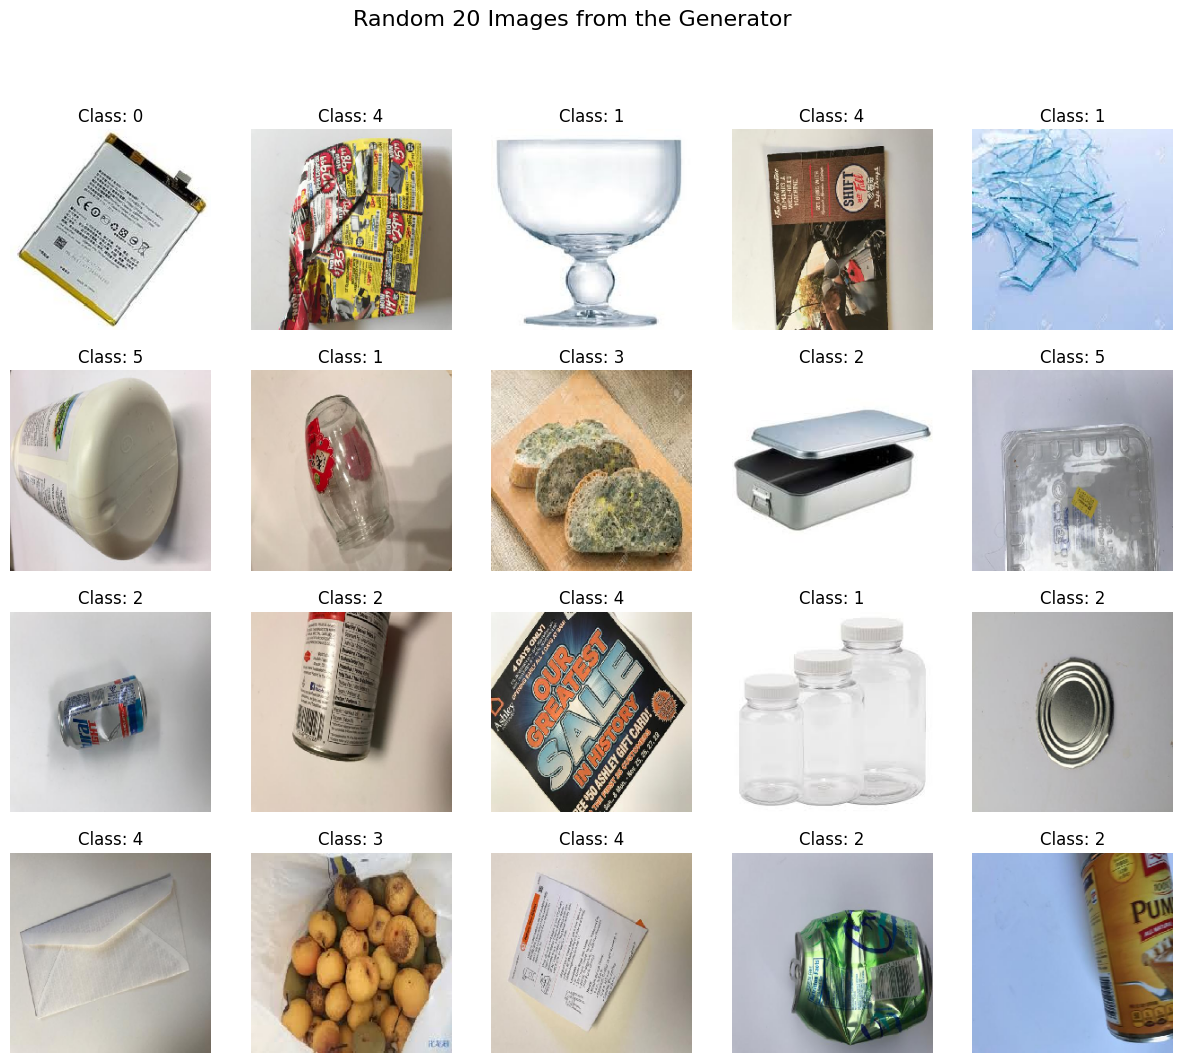

In [4]:
original_data = ImageDataGenerator(rescale=1./255).flow_from_directory(data_path, target_size = (224, 224), batch_size = BATCH_SIZE, class_mode="categorical")
plot_random_images(original_data)

Found 4650 images belonging to 6 classes.


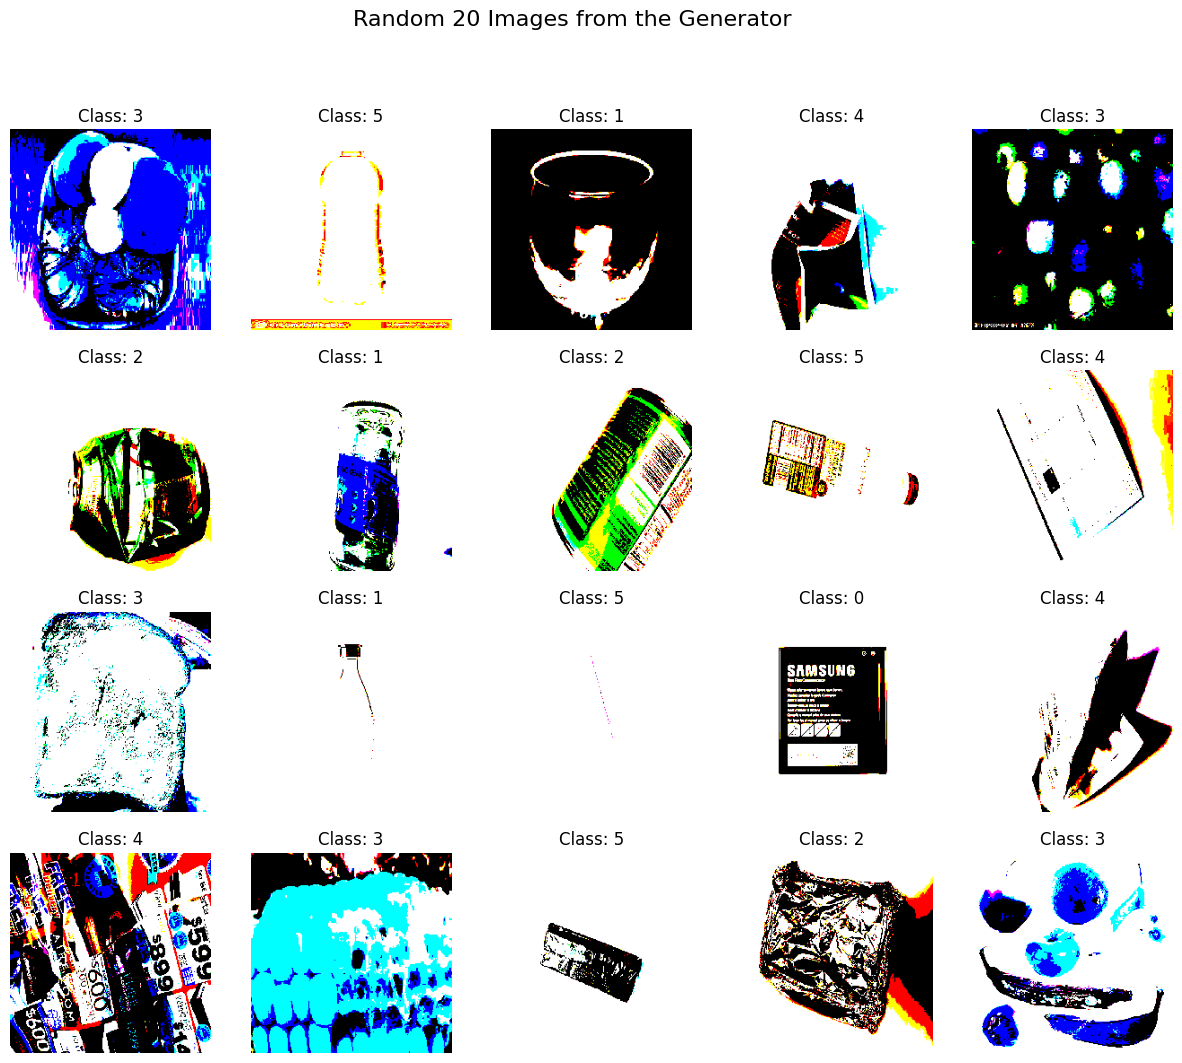

In [5]:
gen_train = ImageDataGenerator(preprocessing_function=preprocess_input) # VGG19 preprocessing
full_data = gen_train.flow_from_directory(data_path, target_size = (224, 224), batch_size = BATCH_SIZE, class_mode="categorical")
plot_random_images(full_data)

In [6]:
# Extract filenames and labels from the DirectoryIterator
filenames = full_data.filenames
labels = full_data.labels
class_mapping = {value: str(key) for key, value in full_data.class_indices.items()}
labels = [class_mapping[label] for label in labels]

filenames[:5], labels[:5]

(['battery/battery1.jpg',
  'battery/battery10.jpg',
  'battery/battery100.jpg',
  'battery/battery101.jpg',
  'battery/battery102.jpg'],
 ['battery', 'battery', 'battery', 'battery', 'battery'])

In [7]:
# Split the data into training and testing sets
train_filenames, test_filenames, train_labels, test_labels = train_test_split(
    filenames, labels, test_size=0.1, random_state=42)

# Create DataFrames for training and testing
train_df = pd.DataFrame({'filename': train_filenames, 'class': train_labels})
test_df = pd.DataFrame({'filename': test_filenames, 'class': test_labels})

# Create separate generators for training and testing using flow_from_dataframe
train_data = gen_train.flow_from_dataframe(train_df, directory=data_path, target_size=(224, 224),
                                           batch_size=BATCH_SIZE, class_mode="categorical",
                                           shuffle=True, seed=42)

test_data = gen_train.flow_from_dataframe(test_df, directory=data_path, target_size=(224, 224),
                                          batch_size=BATCH_SIZE, class_mode="categorical",
                                          shuffle=False)

Found 4185 validated image filenames belonging to 6 classes.
Found 465 validated image filenames belonging to 6 classes.


In [8]:
num_epochs = 200
opt = Adam(learning_rate=0.0001)
model.compile(
    optimizer=opt, 
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
checkpoint = ModelCheckpoint(
    filepath='model.vgg19.keras',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)
early = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

In [9]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 22,127,174 (84.41 MB)

 Trainable params: 2,102,790 (8.02 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [10]:
n_steps = train_data.samples // BATCH_SIZE
n_val_steps = test_data.samples // BATCH_SIZE
n_steps, n_val_steps

(65, 7)

In [11]:
result = model.fit(
    train_data, 
    epochs=num_epochs, 
    steps_per_epoch=n_steps,
    validation_data=test_data, 
    validation_steps=n_val_steps,
    callbacks=[early, checkpoint, reduce_lr]
)

Epoch 1/200


I0000 00:00:1731835425.149127      74 service.cc:145] XLA service 0x7c64180111d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731835425.149180      74 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1731835425.149186      74 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1731835450.716768      74 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 710ms/step - accuracy: 0.6260 - loss: 1.0820
Epoch 1: val_loss improved from inf to 0.32025, saving model to model.vgg19.keras
65/65 ━━━━━━━━━━━━━━━━━━━━ 83s 806ms/step - accuracy: 0.6284 - loss: 1.0747 - val_accuracy: 0.9129 - val_loss: 0.3202 - learning_rate: 1.0000e-04
Epoch 2/200
 1/65 ━━━━━━━━━━━━━━━━━━━━ 22s 345ms/step - accuracy: 0.8438 - loss: 0.4519
Epoch 2: val_loss improved from 0.32025 to 0.13980, saving model to model.vgg19.keras
65/65 ━━━━━━━━━━━━━━━━━━━━ 14s 207ms/step - accuracy: 0.8438 - loss: 0.4519 - val_accuracy: 0.9412 - val_loss: 0.1398 - learning_rate: 1.0000e-04
Epoch 3/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.9431 - loss: 0.1778
Epoch 3: val_loss did not improve from 0.13980
65/65 ━━━━━━━━━━━━━━━━━━━━ 27s 387ms/step - accuracy: 0.9432 - loss: 0.1778 - val_accuracy: 0.9040 - val_loss: 0.2839 - learning_rate: 1.0000e-04
Epoch 4/200
 1/65 ━━━━━━━━━━━━━━━━━━━━ 21s 330ms/step - accuracy: 0.9062 - loss: 0.2177
Epoch 4: 

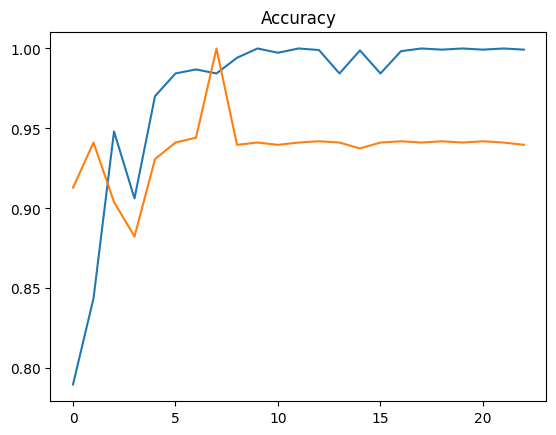

In [12]:
plt.title("Accuracy")
plt.plot(result.history["accuracy"])
plt.plot(result.history["val_accuracy"])
plt.show()

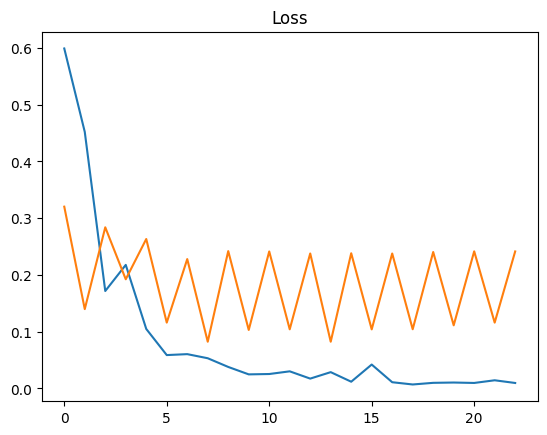

In [13]:
plt.title("Loss")
plt.plot(result.history["loss"])
plt.plot(result.history["val_loss"])
plt.show()

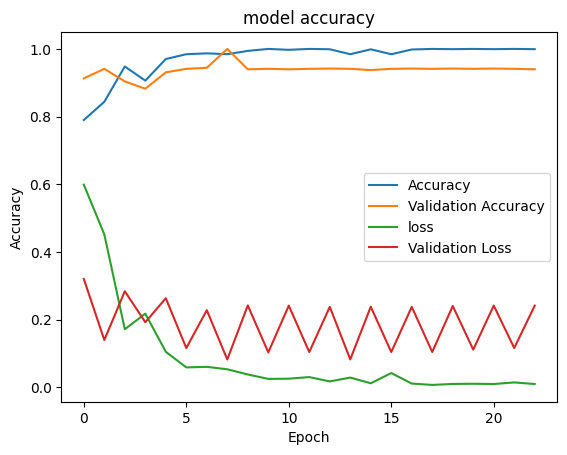

In [14]:
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

In [15]:
model.save("model_vgg19.keras")

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 371ms/step


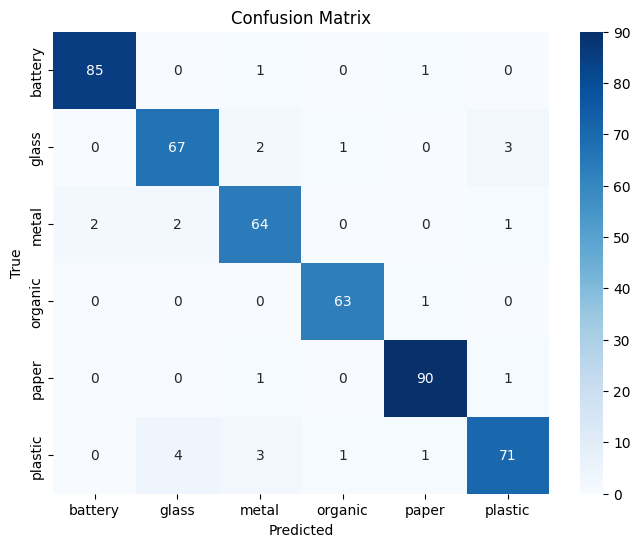

              precision    recall  f1-score   support

     battery       0.98      0.98      0.98        87
       glass       0.92      0.92      0.92        73
       metal       0.90      0.93      0.91        69
     organic       0.97      0.98      0.98        64
       paper       0.97      0.98      0.97        92
     plastic       0.93      0.89      0.91        80

    accuracy                           0.95       465
   macro avg       0.94      0.95      0.94       465
weighted avg       0.95      0.95      0.95       465



In [16]:
predictions = model.predict(test_data)

# Get the predicted class labels
predicted_labels = np.argmax(predictions, axis=1)

# Get the true class labels
true_labels = test_data.classes

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_data.class_indices.keys(),
            yticklabels=test_data.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
class_names = list(test_data.class_indices.keys())
print(classification_report(true_labels, predicted_labels, target_names=class_names))

In [17]:
output_class = ["battery", "glass", "metal","organic", "paper", "plastic"]

def preprocessing_input(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img) # VGG16 preprocess_input
    return img

def plot_images(original, preprocessed):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].imshow(original)
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    # Remove the batch dimension for display
    preprocessed = np.squeeze(preprocessed, axis=0)

    axs[1].imshow(preprocessed)
    axs[1].set_title('Preprocessed Image')
    axs[1].axis('off')

    plt.show()

def predict_user(img_path):
    img = preprocessing_input(img_path)
    plot_images(Image.open(img_path), img)
    predicted_array = model.predict(img)
    predicted_value = output_class[np.argmax(predicted_array)]
    predicted_accuracy = round(np.max(predicted_array) * 100, 2)
    print("Your waste material is", predicted_value, "with", predicted_accuracy, "% accuracy.")

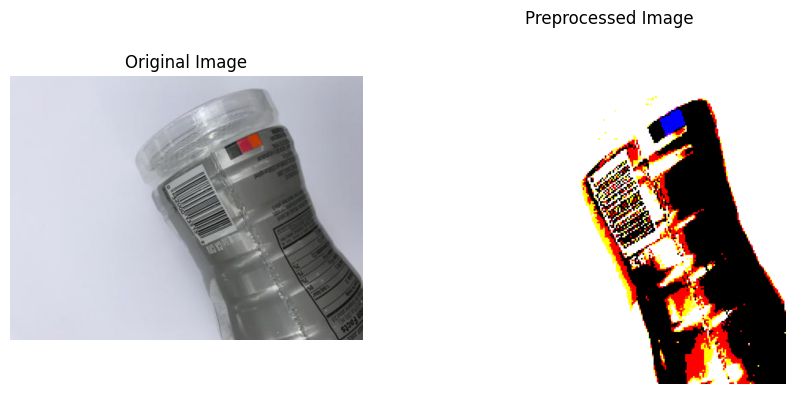

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Your waste material is plastic with 93.58 % accuracy.


In [18]:
predict_user('/kaggle/input/test-data/plastic100.jpg')